# Implémentez un modèle de scoring

In [1]:
#!cat /proc/cpuinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install shap

## Résumé du projet


## Chargement des bibliothèques nécessaires

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy,  os, time,  shutil, re, glob,  os.path
import seaborn as sns
from zipfile import ZipFile
from os import listdir, path
from pathlib import Path
import shap

from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold,train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score,roc_curve,f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,recall_score,precision_score,fbeta_score,average_precision_score

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Données

In [5]:
dir_data = Path('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter') 
dir_fig  = Path('/content/drive/MyDrive/Data_Scientist/FIGURE') 

filetrain=str(dir_data) + '/data_merged_train2use.csv'

best_params_file     =str(dir_data) + '/best_params.npy'
best_params_file_over=str(dir_data) + '/best_params_over.npy'
best_params_file_under=str(dir_data) + '/best_params_under.npy'

filebest=str(dir_data) + '/best_params_file.csv'
file2=str(dir_data) + '/data_pred_unbalanced.csv'
file3=str(dir_data) + '/eval_res_unbalanced.csv'
file4=str(dir_data) + '/cost_res_unbalanced.csv'

file5=str(dir_data) + '/data_pred_over.csv'
file6=str(dir_data) + '/eval_res_over.csv'
file7=str(dir_data) + '/cost_res_over.csv'

file8=str(dir_data) + '/data_pred_under.csv'
file9=str(dir_data) + '/eval_res_under.csv'
file10=str(dir_data) + '/cost_res_under.csv'

file21=str(dir_data) + '/df_FI.csv'
file22=str(dir_data) + '/df_FI1.csv'
file51=str(dir_data) + '/df_FI_over.csv'
file52=str(dir_data) + '/df_FI1_over.csv'
file91=str(dir_data) + '/df_FI_under.csv'
file92=str(dir_data) + '/df_FI1_under.csv'


In [6]:
data =pd.read_csv(filetrain)

### Préparation des données avant la modélisation

In [7]:
X=data.drop('TARGET',axis=1)
Y=data['TARGET']

In [8]:
X=X.drop(['Unnamed: 0'],axis=1)
fullstring='_ID_'
for i in X.columns:
    if fullstring in i:
      X=X.drop([i],axis=1)


In [9]:
seed=42
scalar    = preprocessing.StandardScaler() 
std_scalar = scalar.fit(X) 
X_scaled  = std_scalar.transform(X)
X_scaled  = pd.DataFrame(X_scaled,columns=X.columns)

In [10]:
[X_train,X_test,Y_train,Y_test]=train_test_split(X_scaled,Y,test_size=0.3, random_state=seed)

## Modèlisation

### Modèles utilisées et hyperparamètres à optimiser

In [11]:
Classifiers = {
    "DummyClassifier": DummyClassifier(strategy="most_frequent"),
    "LGBMClassifier" : LGBMClassifier(n_jobs=32),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=32),
    'XGBClassifier': XGBClassifier(nthread=32),
    }

maxdep  = [4, 5, 6]
learrate= [1e-2, 1e-1, 0.15, 0.2]
n_estim = [150,190, 200,210]
n_neighbors=[5, 15, 21, 27, 29,30,35,40,45,50,100,200]
weights= ['uniform','distance']  

params_Classifiers = {
    "DummyClassifier" :   {},    
    "LGBMClassifier":     {'max_depth': maxdep,'learning_rate': learrate,'n_estimators': n_estim ,'eval_metric' :['mlogloss']},   # 'eval_metric' :['mlogloss']  to remove warnings
    'RandomForestClassifier':      {'bootstrap': [True, False],'max_depth': maxdep ,'max_features': [2, 3],'min_samples_leaf': [3, 4, 5],
                                  'min_samples_split': [8, 10, 12],'n_estimators': n_estim },
    "XGBClassifier":      {'max_depth': maxdep,'learning_rate': learrate,'n_estimators': n_estim ,'eval_metric' :['mlogloss']},
  
    } 

### Modèlisation avec un jeu de données déséquilibré

#### Recherche des meilleurs paramètres pour les modèles

In [12]:
def find_best_params(nsplits,X_train, Y_train,X_test,Y_test,Classifiers,params_Classifiers):
  
  best_params = pd.DataFrame()
  #Findex=['Cible predite']    
  frames_test= [] 
  column_Classifiers=[]
  
  for model_idx in Classifiers:
    column_Classifiers.append(model_idx)
    kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=seed)
    #
    print(model_idx)
    model  = Classifiers[model_idx]
    pgrid= params_Classifiers[model_idx]

    grid_search = GridSearchCV(estimator=model , param_grid=pgrid, cv=kfold, scoring ='roc_auc')

    grid_search.fit(X_train, Y_train)
    best_params[model_idx]=[grid_search.best_params_]   
    print(grid_search.best_params_)
  return best_params
  # scoring roc_auc ===> pour gérer le déséquilibre des classes dans un jeu de données

In [13]:
nsplits=3
if path.exists(filebest):
  print('Best params already found')
  param_best =pd.read_csv(filebest)

  listOfStr= param_best.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        param_best=param_best.drop(i, axis=1)

else:
  best_params=find_best_params(nsplits,X_train, Y_train,X_test,Y_test,Classifiers,params_Classifiers)
  best_params.to_csv(filebest)


Best params already found


In [14]:
#param_best['XGBClassifier'][0]

In [15]:
Classifiers_best = { 
    "DummyClassifier"       : DummyClassifier(strategy="most_frequent"),
    "LGBMClassifier"        : LGBMClassifier(eval_metric='mlogloss', learning_rate= 0.1,
                               max_depth=5, n_estimators=200), 
    'RandomForestClassifier': RandomForestClassifier(bootstrap = False,max_depth=6 ,max_features= 3,min_samples_leaf=3,
                                  min_samples_split= 12,n_estimators= 190 ),
    "XGBClassifier"         : XGBClassifier(max_depth=5,learning_rate= 0.1,n_estimators= 210 ,eval_metric='mlogloss'),
  }
  

#### Modelisation avec les meilleur parametres

In [18]:
from numpy.core.records import format_parser
def custom_metric(y_true, y_predi):
    cout_fn=10
    cout_fp=1
    cout_tp=-1
    cout_tn=-1

    (tn, fp, fn, tp) = confusion_matrix(y_true, y_predi,normalize='true').ravel()
    info_metier = (fn*cout_fn + fp*cout_fp + tp* cout_tp + tn*cout_tn)  # à minimiser  
    return info_metier

def modeliser_data_unbalanced(nsplits,X_train, Y_train,X_test,Y_test,Classifiers):

  best_params= {}
  cout_append= []
  frames_test= [] 
  score_value= []
  scores = []
  column_Classifiers=[]
  save_model = pd.DataFrame()
  threshold=[0,0.001,0.002, 0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.011, 
             0.012, 0.013,0.014,0.015, 0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

  frames_FI=pd.DataFrame()
  frames_FI1=pd.DataFrame()
  for model_idx in Classifiers:
    column_Classifiers.append(model_idx)
    print(model_idx)
    model  = Classifiers[model_idx]
    my_model=model.fit(X_train, Y_train)
    #   
    Findex      = str('C.Pred')      +'_' + model_idx
    Findex_proba= str('C.Pred_proba')+'_' + model_idx  
    y_predite   = pd.DataFrame(my_model.predict(X_test) ,index=Y_test.index,columns=[Findex]) 
    y_pred_proba= pd.DataFrame(my_model.predict_proba(X_test)[:,1] ,index=Y_test.index,columns=[Findex_proba])
    
    if model_idx == 'DummyClassifier':
      y_pred      = pd.concat([Y_test,y_predite, y_pred_proba],axis=1)
    else:
      y_pred      = pd.concat([y_predite, y_pred_proba],axis=1)
    frames_test.append(y_pred)

    # Check Feature Importance
    if model_idx != 'DummyClassifier':
      explainer  = shap.TreeExplainer(my_model)
      shap_values= explainer.shap_values(X_test)
      frames_FI[model_idx]=shap_values
      frames_FI1[model_idx]=shap_values[1].ravel()

    # Function cout
    acu_scores= accuracy_score(Y_test, y_predite)
    auc_scores= roc_auc_score(Y_test, y_pred_proba) 
    data      = {'Model':model_idx,'ACCURACY': [acu_scores], 'ROC_AUC':[auc_scores]}  
    scores.append(pd.DataFrame(data) )

    cost_function = []
    cost_ind = []
    for thre in threshold:
      Ypred=(y_pred_proba>thre)
      Ypred = np.array(Ypred > 0) * 1
      cost_function.append(custom_metric(Y_test, Ypred))
      cost_ind.append(thre)
      newname=str('cout') + '_'+ str(model_idx)
    cout    = pd.DataFrame(cost_function,columns=[newname]) 
    cout_append.append(cout)
    if model_idx == 'DummyClassifier':
      idx_cout= pd.DataFrame(cost_ind,columns=['Threshold']) 

    df_pred = pd.concat(frames_test, axis=1)
    
    cost    = pd.concat(cout_append,axis=1)
    cost['Threshold']= idx_cout['Threshold']
    cost      = cost.set_index('Threshold')
    df_results= pd.concat(scores,axis=0)
    df_results= df_results.set_index('Model')
    save_model[model_idx]=[my_model]

  return df_pred, frames_FI, frames_FI1, df_results, cost, save_model


In [19]:
if path.exists(file2):
  print('already found')
  df_pred=pd.read_csv(file2)
  listOfStr= df_pred.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_pred=df_pred.drop(i, axis=1)
        
  eval_res=pd.read_csv(file3)
  eval_res=eval_res.set_index('Model')
  cost_res=pd.read_csv(file4)
  cost_res=cost_res.set_index('Threshold')

  df_FI=pd.read_csv(file21)
  df_FI1=pd.read_csv(file22)
else:
  [df_pred, df_FI, df_FI1, eval_res,cost_res,model_out]=modeliser_data_unbalanced(nsplits, X_train,
                                                            Y_train, X_test, Y_test, Classifiers_best)
  df_pred.to_csv(file2)
  eval_res.to_csv(file3)
  cost_res.to_csv(file4)

  df_FI.to_csv(file21)
  df_FI1.to_csv(file22)

DummyClassifier
LGBMClassifier


In [20]:
def plot_eval(eval_res,sort,titre):
  sel_cols = eval_res.columns
  eval_res[sel_cols].sort_values(sort,
                                 ascending=True,
                                 axis=1).plot.bar(ec='k', width=0.4,ax=axe)

  plt.suptitle(titre,fontweight='bold')
  plt.grid()
  plt.show()

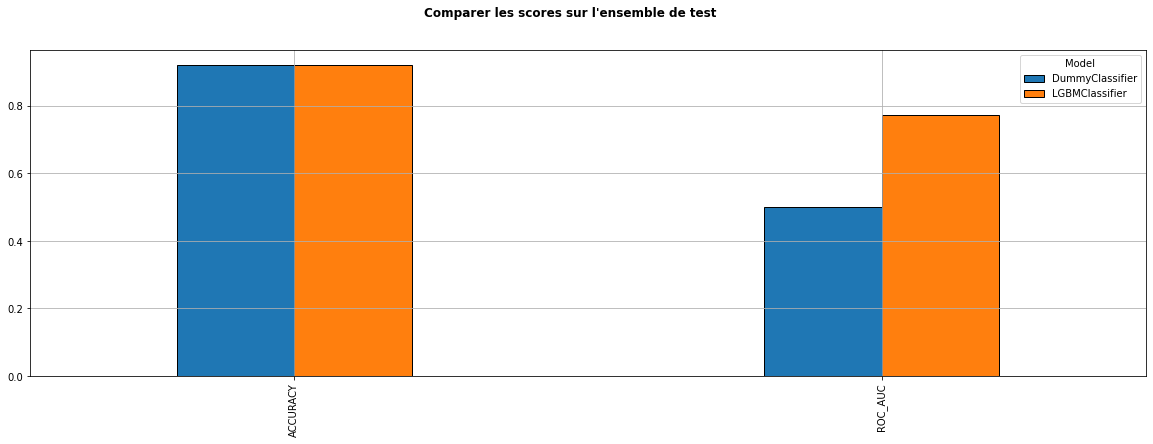

In [21]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(eval_res.T,sort,titre)

#### Métrique métier 

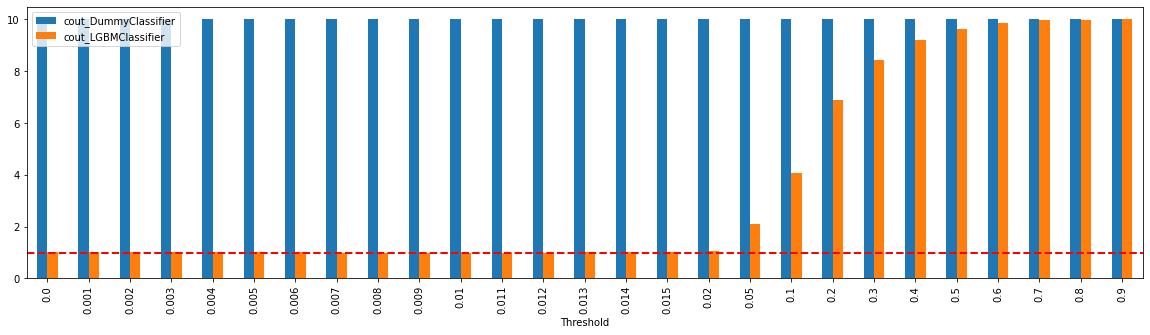

In [22]:
f, (ax1) = plt.subplots(1,1, figsize=(20,5))
qs=cost_res.plot.bar(rot=90,ax=ax1)
qs.axhline(y=cost_res.min().min(), color='r', linestyle='--', lw=2)

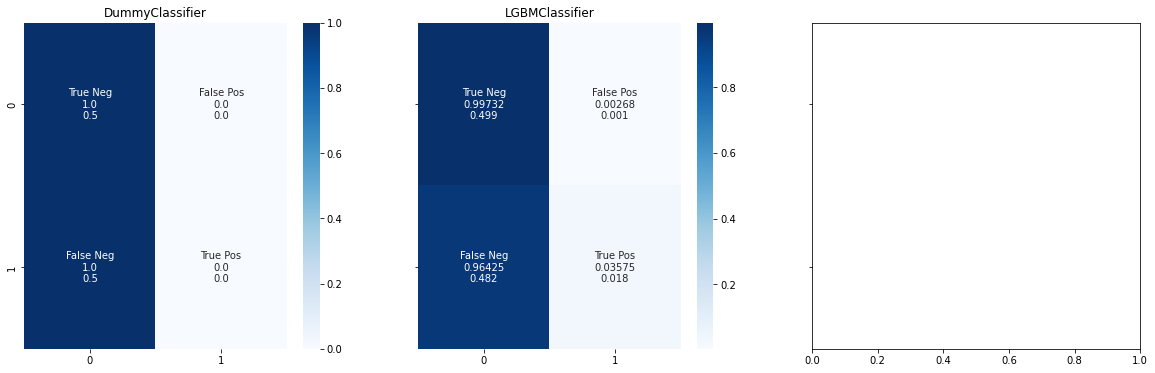

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6),sharey=True)
ax=[ax1,ax2,ax3]
tnx=0

for model_idx in Classifiers_best:
    Findex_prob       = str('C.Pred')      +'_' + model_idx
    Ypred=df_pred[Findex_prob]
    Ytrue=df_pred['TARGET']
    cf_matrix = confusion_matrix(Ytrue, Ypred, normalize    = 'true')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [round(value,5) for value in cf_matrix.flatten()]
    group_percentages = [round(value,3) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=ax[tnx]).set_title(model_idx)
    tnx=tnx+1

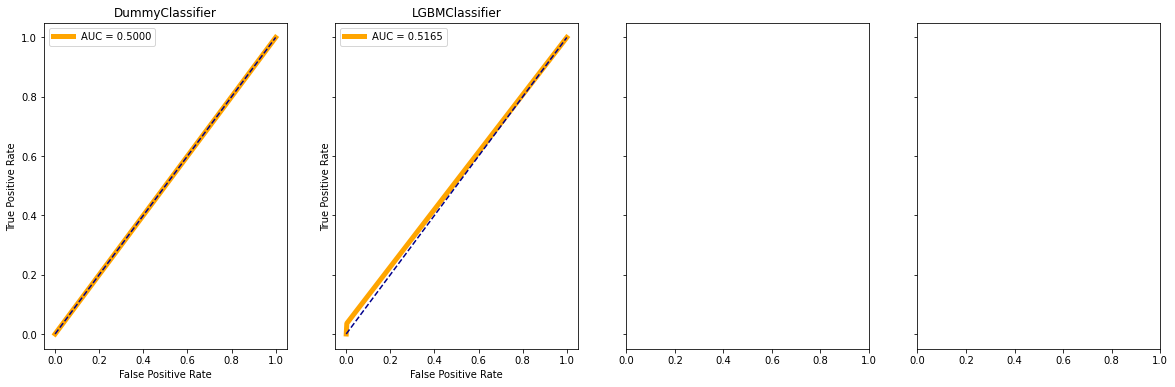

In [24]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20,6),sharey=True)
ax=[ax1,ax2,ax3,ax4]
tnx=0

for model_idx in Classifiers_best: #param_best:
    Findex      = str('C.Pred')      +'_' + model_idx
    Ypred=df_pred[Findex]
    Ytrue=df_pred['TARGET']
    fpr,tpr,_ = roc_curve(Ytrue,Ypred)
    roc_auc= roc_auc_score(Ytrue,Ypred)
    ax[tnx].plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f'%roc_auc)
    ax[tnx].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax[tnx].set_xlabel('False Positive Rate')
    ax[tnx].set_ylabel('True Positive Rate')
    ax[tnx].set_title(model_idx)
    ax[tnx].legend()
    tnx=tnx+1

#### Check Feature Importance

In [29]:
shap_valuess=pd.DataFrame()
shap_valuess1=pd.DataFrame()#

for model_idx in Classifiers_best: #param_best:
    model  = param_best[model_idx]
    if model_idx !='DummyClassifier':
        print(model_idx)
        my_model = Classifiers_best[model_idx].fit(X_train,Y_train)
        explainer = shap.TreeExplainer(my_model)
        shap_values = explainer.shap_values(X_test)
        shap_valuess[model_idx]=shap_values
        shap_valuess1[model_idx]=shap_values[1].ravel()
      

LGBMClassifier


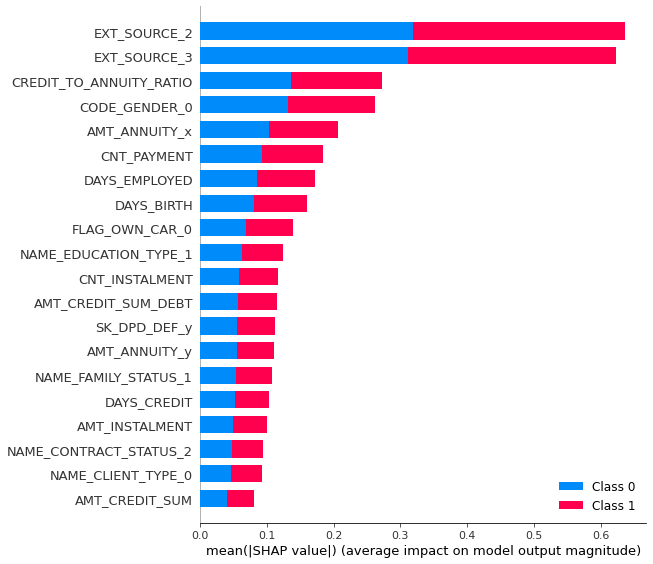

In [31]:
for model_idx in Classifiers_best:
  if model_idx!= 'DummyClassifier':
    shap.summary_plot(shap_values, X_test)

Comme le montre la figure ci-dessus, des caractéristiques telles que ext_source_2, ext_source_3, code_gender_0, credit_to_annuity_ratio, AMT_ANNUITY et CNT_PAYMENT sont apparues comme les six caractéristiques les plus influentes dans décisions d’octroi de crédit  

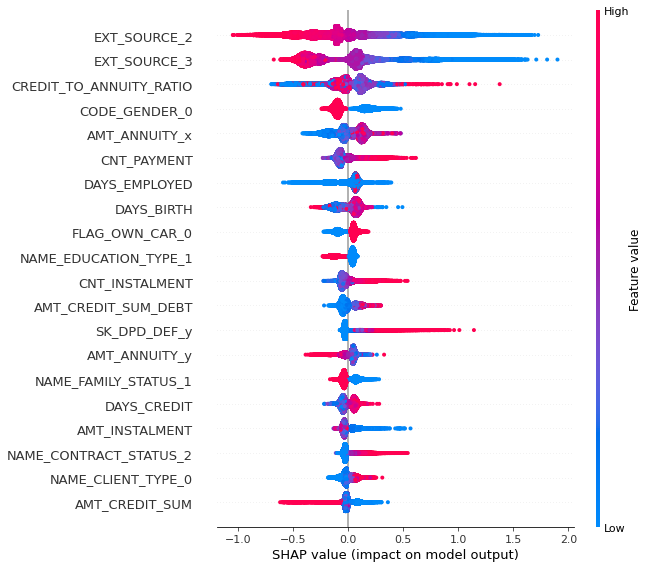

In [32]:
for model_idx in Classifiers_best:
  if model_idx!= 'DummyClassifier':
    shap.summary_plot(shap_values[1], X_test)

In [ ]:
for model_idx in param_best:
  if model_idx=='XGBClassifier':
     shap.summary_plot(df_FI1[model_idx], X_test)
    #shap.summary_plot(shap_values[1], X_test)

Ext_source_2, ext_source_3 and code_gender_0 tends to push the prediction toward downward mobility (negative). (reduit les chances d'une reponse negative???)
code_gender_0___ home / femme????

On the other hand, the higher values of credit_to_annuity_ratio, amt_annuity_x and CNT_PAYMENT pushes the prediction toward upward mobility  (positive)

### Modèlisation avec un jeu de données équilibré - en utilisant la technique du suréchantillonnage

In [ ]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_over, Y_train_over = sm.fit_resample(X_train, Y_train)


#### Recherche des meilleurs paramètres pour les modèles

In [ ]:
if path.exists(best_params_file_over):
  print('Best params already found')
  print(np.load('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter/best_params.npy', allow_pickle=True))
else:
  best_params_over=find_best_params(nsplits,X_train_over, Y_train_over,X_test,Y_test,Classifiers,params_Classifiers)
  np.save(best_params_file_over, best_params_over)

In [ ]:

Classifiers_best_over = { 
    "DummyClassifier"       : DummyClassifier(strategy="most_frequent"),
    "LGBMClassifier"        : LGBMClassifier(eval_metric='mlogloss', learning_rate= 0.1,
                               max_depth=6, n_estimators=210), 
    'RandomForestClassifier': RandomForestClassifier(bootstrap = False,max_depth=maxdep ,max_features= 3,min_samples_leaf=5,
                                  min_samples_split= 12,n_estimators= n_estim ),
    "XGBClassifier"         : XGBClassifier(max_depth=maxdep,learning_rate= learrate,n_estimators= n_estim ,eval_metric=['mlogloss']),
  }

#### Modelisation avec les meilleur parametres

In [ ]:
if path.exists(file5):
  print('already found')
  df_pred_over=pd.read_csv(file5)
  listOfStr= df_pred_over.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_pred_over=df_pred_over.drop(i, axis=1)
        
  eval_res_over=pd.read_csv(file6)
  eval_res_over=eval_res_over.set_index('Model')
  cost_res_over=pd.read_csv(file7)
  cost_res_over=cost_res_over.set_index('Threshold')
  df_FI_over=pd.read_csv(file51)
  df_FI1_over=pd.read_csv(file52)
else:
  [df_pred_over, df_FI_over, df_FI1_over,eval_res_over,cost_res_over,model_out_over]=modeliser_data_unbalanced(nsplits,X_train_over, Y_train_over,X_test,Y_test,Classifiers_best_over)
  df_pred_over.to_csv(file5)
  eval_res_over.to_csv(file6)
  cost_res_over.to_csv(file7)
  df_FI_over.to_csv(file51)
  df_FI1_over.to_csv(file52)




In [ ]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(eval_res_over.T,sort,titre)

#### Check Feature Importance

#### Métrique métier

In [ ]:
f, (ax1) = plt.subplots(1,1, figsize=(20,5))
qs=cost_res_over.plot.bar(rot=90,ax=ax1)
qs.axhline(y=cost_res_over.min().min(), color='r', linestyle='--', lw=2)

In [ ]:
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6),sharey=True)
ax=[ax1,ax2,ax3]
tnx=0

for model_idx in param_best:
    Findex      = str('C.Pred')      +'_' + model_idx
    Ypred=df_pred_over[Findex]
    Ytrue=df_pred_over['TARGET']
    cf_matrix = confusion_matrix(Ytrue, Ypred, normalize    = 'true')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [round(value,3) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=ax[tnx]).set_title(model_idx)
    tnx=tnx+1

Undersampling

In [ ]:
import imblearn
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(version=1)
# transform the dataset
X_train_under, Y_train_under = undersample.fit_resample(X_train, Y_train)



In [ ]:
if path.exists(best_params_file_under):
  print('Best params already found')
  print(np.load('/content/drive/MyDrive/Data_Scientist/DATA/P7_inter/best_params_under.npy', allow_pickle=True))
else:
  best_params_under=find_best_params(nsplits,X_train_under, Y_train_under,X_test,Y_test,Classifiers,params_Classifiers)
  np.save(best_params_file_under, best_params_under)

In [ ]:
Classifiers_best_under = { 
    "DummyClassifier"       : DummyClassifier(strategy="most_frequent"),
    "LGBMClassifier"        : LGBMClassifier(eval_metric='mlogloss', learning_rate= 0.2,
                               max_depth=5, n_estimators=210), 
    'RandomForestClassifier': RandomForestClassifier(bootstrap = False,max_depth=maxdep ,max_features= 3,min_samples_leaf=5,
                                  min_samples_split= 12,n_estimators= n_estim ),
    "XGBClassifier"         : XGBClassifier(max_depth=maxdep,learning_rate= learrate,n_estimators= n_estim ,eval_metric=['mlogloss']),
  }

In [ ]:
if path.exists(file8):
  print('already found')
  df_pred_under=pd.read_csv(file8)
  listOfStr= df_pred_under.columns
  for i in listOfStr:
     if 'Unnamed' in i:
        df_pred_under=df_pred_under.drop(i, axis=1)
        
  eval_res_under=pd.read_csv(file9)
  eval_res_under=eval_res_under.set_index('Model')
  cost_res_under=pd.read_csv(file10)
  cost_res_under=cost_res_under.set_index('Threshold')
else:
  [df_pred_under,eval_res_under,cost_res_under,model_out_under]=modeliser_data_unbalanced(nsplits,X_train_under, Y_train_under,X_test,Y_test,Classifiers_best_under)
  df_pred_under.to_csv(file8)
  eval_res_under.to_csv(file9)
  cost_res_under.to_csv(file10)

In [ ]:
f, axe = plt.subplots(1,1, figsize=(20,6))

sort='ROC_AUC'
titre="Comparer les scores sur l'ensemble de test"
plot_eval(eval_res_under.T,sort,titre)

In [ ]:
f, (ax1) = plt.subplots(1,1, figsize=(20,5))
qs=cost_res_under.plot.bar(rot=90,ax=ax1)
qs.axhline(y=cost_res_under.min().min(), color='r', linestyle='--', lw=2)

In [ ]:

f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,6),sharey=True)
ax=[ax1,ax2,ax3]
tnx=0

for model_idx in param_best:
    Findex      = str('C.Pred')      +'_' + model_idx
    Ypred=df_pred_under[Findex]
    Ytrue=df_pred_under['TARGET']
    cf_matrix = confusion_matrix(Ytrue, Ypred, normalize    = 'true')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [round(value,3) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=ax[tnx]).set_title(model_idx)
    tnx=tnx+1